# Import libraries

In [ ]:
import pynvml

pynvml.nvmlInit()
handle = pynvml.nvmlDeviceGetHandleByIndex(0)
device_name = pynvml.nvmlDeviceGetName(handle)

if device_name not in [b'Tesla T4', b'Tesla P100-PCIE-16GB']:
  print('Nooooooo')
else:
  print('Woo! You got the right kind of GPU!')

print(device_name)

Woo! You got the right kind of GPU!
b'Tesla T4'


In [ ]:
!pip install gensim --upgrade
!pip install keras --upgrade
!pip install pandas --upgrade

     |████████████████████████████████| 24.2MB 129kB/s 
  Found existing installation: gensim 3.6.0
    Uninstalling gensim-3.6.0:
      Successfully uninstalled gensim-3.6.0
  Found existing installation: Keras 2.3.1
    Uninstalling Keras-2.3.1:
      Successfully uninstalled Keras-2.3.1


     |████████████████████████████████| 10.5MB 6.3MB/s 
ERROR: google-colab 1.0.0 has requirement pandas~=1.0.0; python_version >= "3.0", but you'll have pandas 1.1.0 which is incompatible.
  Found existing installation: pandas 1.0.5
    Uninstalling pandas-1.0.5:
      Successfully uninstalled pandas-1.0.5


In [ ]:
import pandas as pd
import re
import numpy as np
import matplotlib.pyplot as plt

import nltk
from nltk.corpus import stopwords
from  nltk.stem import SnowballStemmer
import time

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.manifold import TSNE
from sklearn.feature_extraction.text import TfidfVectorizer

import gensim

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers.core import Activation, Dropout, Dense
from keras.layers import Flatten
from keras.layers import GlobalMaxPooling1D
from keras.layers.embeddings import Embedding
from keras.layers import LSTM, Bidirectional
from keras.layers import Conv1D
from keras import utils
from keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
import keras
import itertools
import pickle

# Parametrs

In [ ]:
TEXT_CLEANING_RE = "@\S+|https?:\S+|http?:\S|[^А-Яа-я0-9]+"

# WORD2VEC paramets
W2V_SIZE = 300
W2V_WINDOW = 7
W2V_EPOCH = 32
W2V_MIN_COUNT = 10

SEQUENCE_LENGTH = 300

# Download datasets

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
df_twit = pd.read_csv("/content/drive/My Drive/Datasets/lema_twits_v3.csv", delimiter='<')
df_news = pd.read_csv("/content/drive/My Drive/Datasets/lema_news.csv", delimiter='<')
# df_news = pd.read_json("/content/drive/My Drive/Datasets/train.json")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
df_twit

,sentiment,twit
0,0,коллега покидать сегодня плакать
1,0,это воскресение это погода день
2,0,палатка вверх дождь идти
3,0,желание мочь приходить
4,0,чувствовать действительно ужасно несколько отн...
...,...,...
1609282,0,каждый хотеть исправлять 7
1609283,0,скучать вправлять мозги равный скучать
1609284,0,школа гавно это идти
1609285,0,тауриэль грустить обнимать


# Preprocess data

In [ ]:
!wget http://download.cdn.yandex.net/mystem/mystem-3.0-linux3.1-64bit.tar.gz
!tar -xvf mystem-3.0-linux3.1-64bit.tar.gz
!cp mystem /bin

--2020-07-31 03:49:23--  http://download.cdn.yandex.net/mystem/mystem-3.0-linux3.1-64bit.tar.gz
Resolving download.cdn.yandex.net (download.cdn.yandex.net)... 5.45.205.243, 5.45.205.244, 5.45.205.245, ...
Connecting to download.cdn.yandex.net (download.cdn.yandex.net)|5.45.205.243|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: http://cache-mskm909.cdn.yandex.net/download.cdn.yandex.net/mystem/mystem-3.0-linux3.1-64bit.tar.gz [following]
--2020-07-31 03:49:23--  http://cache-mskm909.cdn.yandex.net/download.cdn.yandex.net/mystem/mystem-3.0-linux3.1-64bit.tar.gz
Resolving cache-mskm909.cdn.yandex.net (cache-mskm909.cdn.yandex.net)... 5.45.220.19, 2a02:6b8:0:2002::1a
Connecting to cache-mskm909.cdn.yandex.net (cache-mskm909.cdn.yandex.net)|5.45.220.19|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 16457938 (16M) [application/octet-stream]
Saving to: ‘mystem-3.0-linux3.1-64bit.tar.gz’

mystem-3.0-linux3.1 100%[===================>]  1

In [ ]:
nltk.download("stopwords")
from nltk.corpus import stopwords
from pymystem3 import Mystem
from string import punctuation

mystem = Mystem() 
russian_stopwords = stopwords.words("russian")

def preprocess(text):
    tokens = mystem.lemmatize(text.lower())
    tokens = [token for token in tokens if token not in russian_stopwords\
              and token != " " \
              and token.strip() not in punctuation]
    
    text = " ".join(tokens)
    
    return text

nltk.download('stopwords')
stop_words = stopwords.words("russian")
stemmer = SnowballStemmer("russian")

def preprocess_text(text):
    # Remove link,user and special characters
    text = re.sub(TEXT_CLEANING_RE, ' ', str(text).lower()).strip()
    tokens = []
    for token in text.split():
        if token not in russian_stopwords:
          tokens.append(token)

    text = " ".join(tokens)

    # lematize text
    tokens = mystem.lemmatize(text.lower())
    tokens = [token for token in tokens if token not in russian_stopwords\
              and token != " " \
              and token.strip() not in punctuation]
    
    text = " ".join(tokens)
    
    return text

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
%%time
df_twit.twit = df_twit.twit.apply(lambda x: preprocess(x))
df_news.text = df_news.text.apply(lambda x: preprocess(x))

CPU times: user 41.7 s, sys: 2.91 s, total: 44.6 s
Wall time: 2min 52s


In [ ]:
%%time
df_twit.twit = df_twit.twit.apply(lambda x: preprocess_text(x))
df_news.text = df_news.text.apply(lambda x: preprocess_text(x))

CPU times: user 34.4 s, sys: 241 ms, total: 34.7 s
Wall time: 34.7 s


In [ ]:
df_twit_train, df_twit_test = train_test_split(df_twit, test_size=0.2, random_state=42)
print("TRAIN size:", len(df_twit_train))
print("TEST size:", len(df_twit_test))

TRAIN size: 1294154
TEST size: 323539


In [ ]:
import csv
with open('/content/drive/My Drive/Datasets/lema_news.csv', 'w', newline='') as file:
    fieldnames = ['sentiment', 'text']
    writer = csv.DictWriter(file, fieldnames=fieldnames, delimiter='<')
    writer.writeheader()
               
    for i in range(len(df_news)):        
        sent = df_news.sentiment[i]
        sentiment = 1 if sent == 'positive' else 0
        text = df_news.text[i]       
        writer.writerow({'sentiment': sentiment, 'text': text}) 

# Word2Vec

In [ ]:
w2v_file = open("/content/drive/My Drive/Models/model_w2v_rusvectors.txt", encoding='utf8')
embeddings_dictionary = dict()
for line in w2v_file:
    records = line.split()
    word = ""
    for char in records[0]:
        if char != "_":
            word += char
        else:
            break
    vector_dimensions = np.asarray(records[1:], dtype='float32')
    embeddings_dictionary[word] = vector_dimensions
w2v_file.close()

# Tokenaizer

In [ ]:
%%time
tokenizer = Tokenizer()
tokenizer.fit_on_texts(list(df_news.text) + list(df_twit.twit))
vocab_size = len(tokenizer.word_index) + 1
print("Total words", vocab_size)

Total words 218489
CPU times: user 32.3 s, sys: 92.4 ms, total: 32.4 s
Wall time: 32.4 s


In [ ]:
x_train = pad_sequences(tokenizer.texts_to_sequences(list(df_news.text) + list(df_twit_train.twit)), maxlen=SEQUENCE_LENGTH)
x_test = pad_sequences(tokenizer.texts_to_sequences(df_twit_test.twit), maxlen=SEQUENCE_LENGTH)

In [ ]:
y_train = np.array([1 if int(sentiment) == 1 else 0 for sentiment in (list(df_news.sentiment) + list(df_twit_train.sentiment))])
y_test = np.array([1 if int(sentiment) == 1 else 0 for sentiment in df_twit_test.sentiment])

In [ ]:
y_train = y_train.reshape(-1, 1)
y_test = y_test.reshape(-1, 1)

# Embedding

In [ ]:
embedding_matrix = np.zeros((vocab_size, W2V_SIZE))
for word, index in tokenizer.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector
print(embedding_matrix.shape)

(218489, 300)


In [ ]:
embedding_layer = Embedding(vocab_size, W2V_SIZE, weights=[embedding_matrix], input_length=SEQUENCE_LENGTH, trainable=False)

# Model

In [ ]:
model = Sequential()
model.add(embedding_layer)
model.add(Dropout(0.5))
model.add(Bidirectional(LSTM(100, dropout=0.2, return_sequences=True)))
# model.add(Conv1D(128, 5))
model.add(Dense(6, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 300, 300)          65546700  
_________________________________________________________________
dropout (Dropout)            (None, 300, 300)          0         
_________________________________________________________________
bidirectional (Bidirectional (None, 300, 200)          320800    
_________________________________________________________________
dense (Dense)                (None, 300, 6)            1206      
_________________________________________________________________
dense_1 (Dense)              (None, 300, 1)            7         
Total params: 65,868,713
Trainable params: 322,013
Non-trainable params: 65,546,700
_________________________________________________________________


In [ ]:
model.compile(loss='binary_crossentropy',
              optimizer="adam",
              metrics=['accuracy'])

In [ ]:
callbacks = [ReduceLROnPlateau(monitor='val_loss', patience=5, cooldown=0),
            EarlyStopping(monitor='val_accuracy', min_delta=1e-4, patience=5),
            # ModelCheckpoint(filepath='/content/drive/My Drive/Emotion/model.{epoch:02d}-{val_loss:.2f}.h5')
            ]

In [ ]:
%%time
BATCH_SIZE = 128
EPOCHS = 8
history = model.fit(x_train, y_train,
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS,
                    validation_data=(x_test, y_test),
                    verbose=1,
                    callbacks=callbacks)

Epoch 1/8
12703/12703 [==============================] - 899s 71ms/step - loss: 0.6679 - accuracy: 0.5834 - val_loss: 0.5712 - val_accuracy: 0.7047 - lr: 0.0010
Epoch 2/8
12703/12703 [==============================] - 907s 71ms/step - loss: 0.5694 - accuracy: 0.6996 - val_loss: 0.5298 - val_accuracy: 0.7331 - lr: 0.0010
Epoch 3/8
12703/12703 [==============================] - 909s 72ms/step - loss: 0.5521 - accuracy: 0.7141 - val_loss: 0.5213 - val_accuracy: 0.7382 - lr: 0.0010
Epoch 4/8
12703/12703 [==============================] - 909s 72ms/step - loss: 0.5454 - accuracy: 0.7190 - val_loss: 0.5171 - val_accuracy: 0.7423 - lr: 0.0010
Epoch 5/8
 6597/12703 [==============>...............] - ETA: 6:41 - loss: 0.5419 - accuracy: 0.7219Buffered data was truncated after reaching the output size limit.

In [ ]:
KERAS_MODEL = "/content/drive/My Drive/Models/model_lema_twit_news.h5"
# WORD2VEC_MODEL = "/content/drive/My Drive/Emotion/model_with_news.w2v"
TOKENIZER_MODEL = "/content/drive/My Drive/Tokenizer/tokenizer_twit_news.pkl"
# ENCODER_MODEL = "/content/drive/My Drive/Emotion/encoder_v3.pkl"

model.save(KERAS_MODEL)
# w2v_model.save(WORD2VEC_MODEL)
pickle.dump(tokenizer, open(TOKENIZER_MODEL, "wb"), protocol=0)# 

In [ ]:
%%time
score = model.evaluate(x_test, y_test, batch_size=BATCH_SIZE)
print()
print("ACCURACY:",score[1])
print("LOSS:",score[0])

2528/2528 [==============================] - 82s 32ms/step - loss: 0.5118 - accuracy: 0.7457

ACCURACY: 0.7457343935966492
LOSS: 0.5117913484573364
CPU times: user 1min, sys: 3.86 s, total: 1min 4s
Wall time: 1min 22s


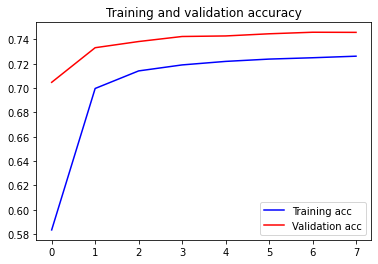

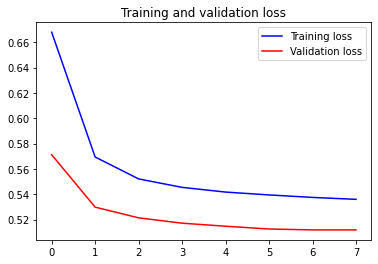

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
 
epochs = range(len(acc))
 
plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
 
plt.figure()
 
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
 
plt.show()

In [ ]:
%%time
cnf_matrix = confusion_matrix(y_test_1d, y_pred_1d)
plt.figure(figsize=(12,12))
plot_confusion_matrix(cnf_matrix, classes=df_train.sentiment.unique(), title="Confusion matrix")
plt.show()

In [ ]:
print(classification_report(y_test_1d, y_pred_1d))

In [ ]:
accuracy_score(y_test_1d, y_pred_1d)

# Load Model

In [ ]:
from keras.models import load_model
from google.colab import drive
drive.mount('/content/drive')
# model = load_model('/content/drive/My Drive/Models/model_lema_24_epochs.h5')
with open("/content/drive/My Drive/Tokenizer/tokenizer_twit.pkl", 'rb') as file:
    tokenizer = pickle.load(file)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import tensorflow as tf 
model = tf.keras.models.load_model('/content/drive/My Drive/Models/model_lema_16_epochs.h5')

# Predict

In [ ]:
SENTIMENT_THRESHOLDS = [0.4, 0.7]

def decode_sentiment(score, include_neutral=True):
    if include_neutral:        
        label = 'NEUTRAL'
        if score <= SENTIMENT_THRESHOLDS[0]:
            label = 'NEGATIVE'
        elif score >= SENTIMENT_THRESHOLDS[1]:
            label = 'POSITIVE'

        return label
    else:
        return 'NEGATIVE' if score < 0.5 else 'POSITIVE'

def predict(text):
    start_at = time.time()

    text = preprocess(text)
    text = preprocess_text(text)
    
    x_test = pad_sequences(tokenizer.texts_to_sequences([text]), maxlen=SEQUENCE_LENGTH)

    score = model.predict([x_test])[0][0]

    label = decode_sentiment(score)

    return {"label": label, "score": float(score),
       "elapsed_time": time.time()-start_at} 

In [ ]:
predict('все умерли и все рады')

{'elapsed_time': 1.0006814002990723,
 'label': 'NEUTRAL',
 'score': 0.457851380109787}

In [ ]:
predict('фильм показался скучным и затянутым')

{'elapsed_time': 0.06454300880432129,
 'label': 'NEGATIVE',
 'score': 0.15616866946220398}

In [ ]:
predict('капец ты классный чувак')

{'elapsed_time': 0.06136608123779297,
 'label': 'NEGATIVE',
 'score': 0.31543633341789246}

In [ ]:
predict('ты классный чувак')

{'elapsed_time': 0.07830500602722168,
 'label': 'POSITIVE',
 'score': 0.8993818759918213}

In [ ]:
predict('мы прекращаем сотрудничество с вами')

{'elapsed_time': 0.06879305839538574,
 'label': 'NEUTRAL',
 'score': 0.4033515751361847}

In [ ]:
predict('мы начинаем сотрудничество с вами')

{'elapsed_time': 0.05632948875427246,
 'label': 'POSITIVE',
 'score': 0.7642225027084351}

In [ ]:
predict('мы требуем увольнения десяти сотрудников')

{'elapsed_time': 0.057662010192871094,
 'label': 'NEGATIVE',
 'score': 0.3939967751502991}

In [ ]:
predict('акции нашей компании возрасли')

{'elapsed_time': 0.06112265586853027,
 'label': 'POSITIVE',
 'score': 0.7553085088729858}

In [ ]:
predict('акции нашей компании обвалились')

{'elapsed_time': 0.06071662902832031,
 'label': 'NEGATIVE',
 'score': 0.13159766793251038}

In [ ]:
predict('Ваша фирма задолжала крупную сумму денег')

{'elapsed_time': 0.07688760757446289,
 'label': 'NEUTRAL',
 'score': 0.6006802320480347}

In [ ]:
predict('хорошо давайте попробуем')

{'elapsed_time': 0.058194875717163086,
 'label': 'POSITIVE',
 'score': 0.8215811252593994}